문제정의 : 타이타닉 생존자 예측 데이터 셋 사용하여 유무를 예측하는 이진 분류 문제로 정의 <br>
사망: 0, 생존: 1

라이브러리 임포트

In [1]:
# Libraries for reading and handling the data
import numpy as np
import pandas as pd
import re

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Libraries for creating ML model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Library for Analysing the ML model
from sklearn import metrics

데이터 준비하기

In [2]:
train_path = '/content/drive/MyDrive/data_analysis_references/csv_files_collection/accident_files/train.csv'
target ='Survived'
index ='PassengerId'

dtypes = ({
    'Survived': bool, 
    'Pclass':   'category', 
    'Name':     'category',
    'Sex':      'category',
    'Age':      float,
    'SibSp':    int,
    'Parch':    int,
    'Ticket':  'category',
    'Fare':     float,
    'Cabin':   'category',
    'Embarked':'category'
})

titanic = pd.read_csv(train_path,index_col=index, dtype=dtypes)

In [3]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    bool    
 1   Pclass    891 non-null    category
 2   Name      891 non-null    category
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    category
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    category
 10  Embarked  889 non-null    category
dtypes: bool(1), category(6), float64(2), int64(2)
memory usage: 122.2 KB


데이터 시각화

In [5]:
titanic['Survived'].value_counts()

False    549
True     342
Name: Survived, dtype: int64

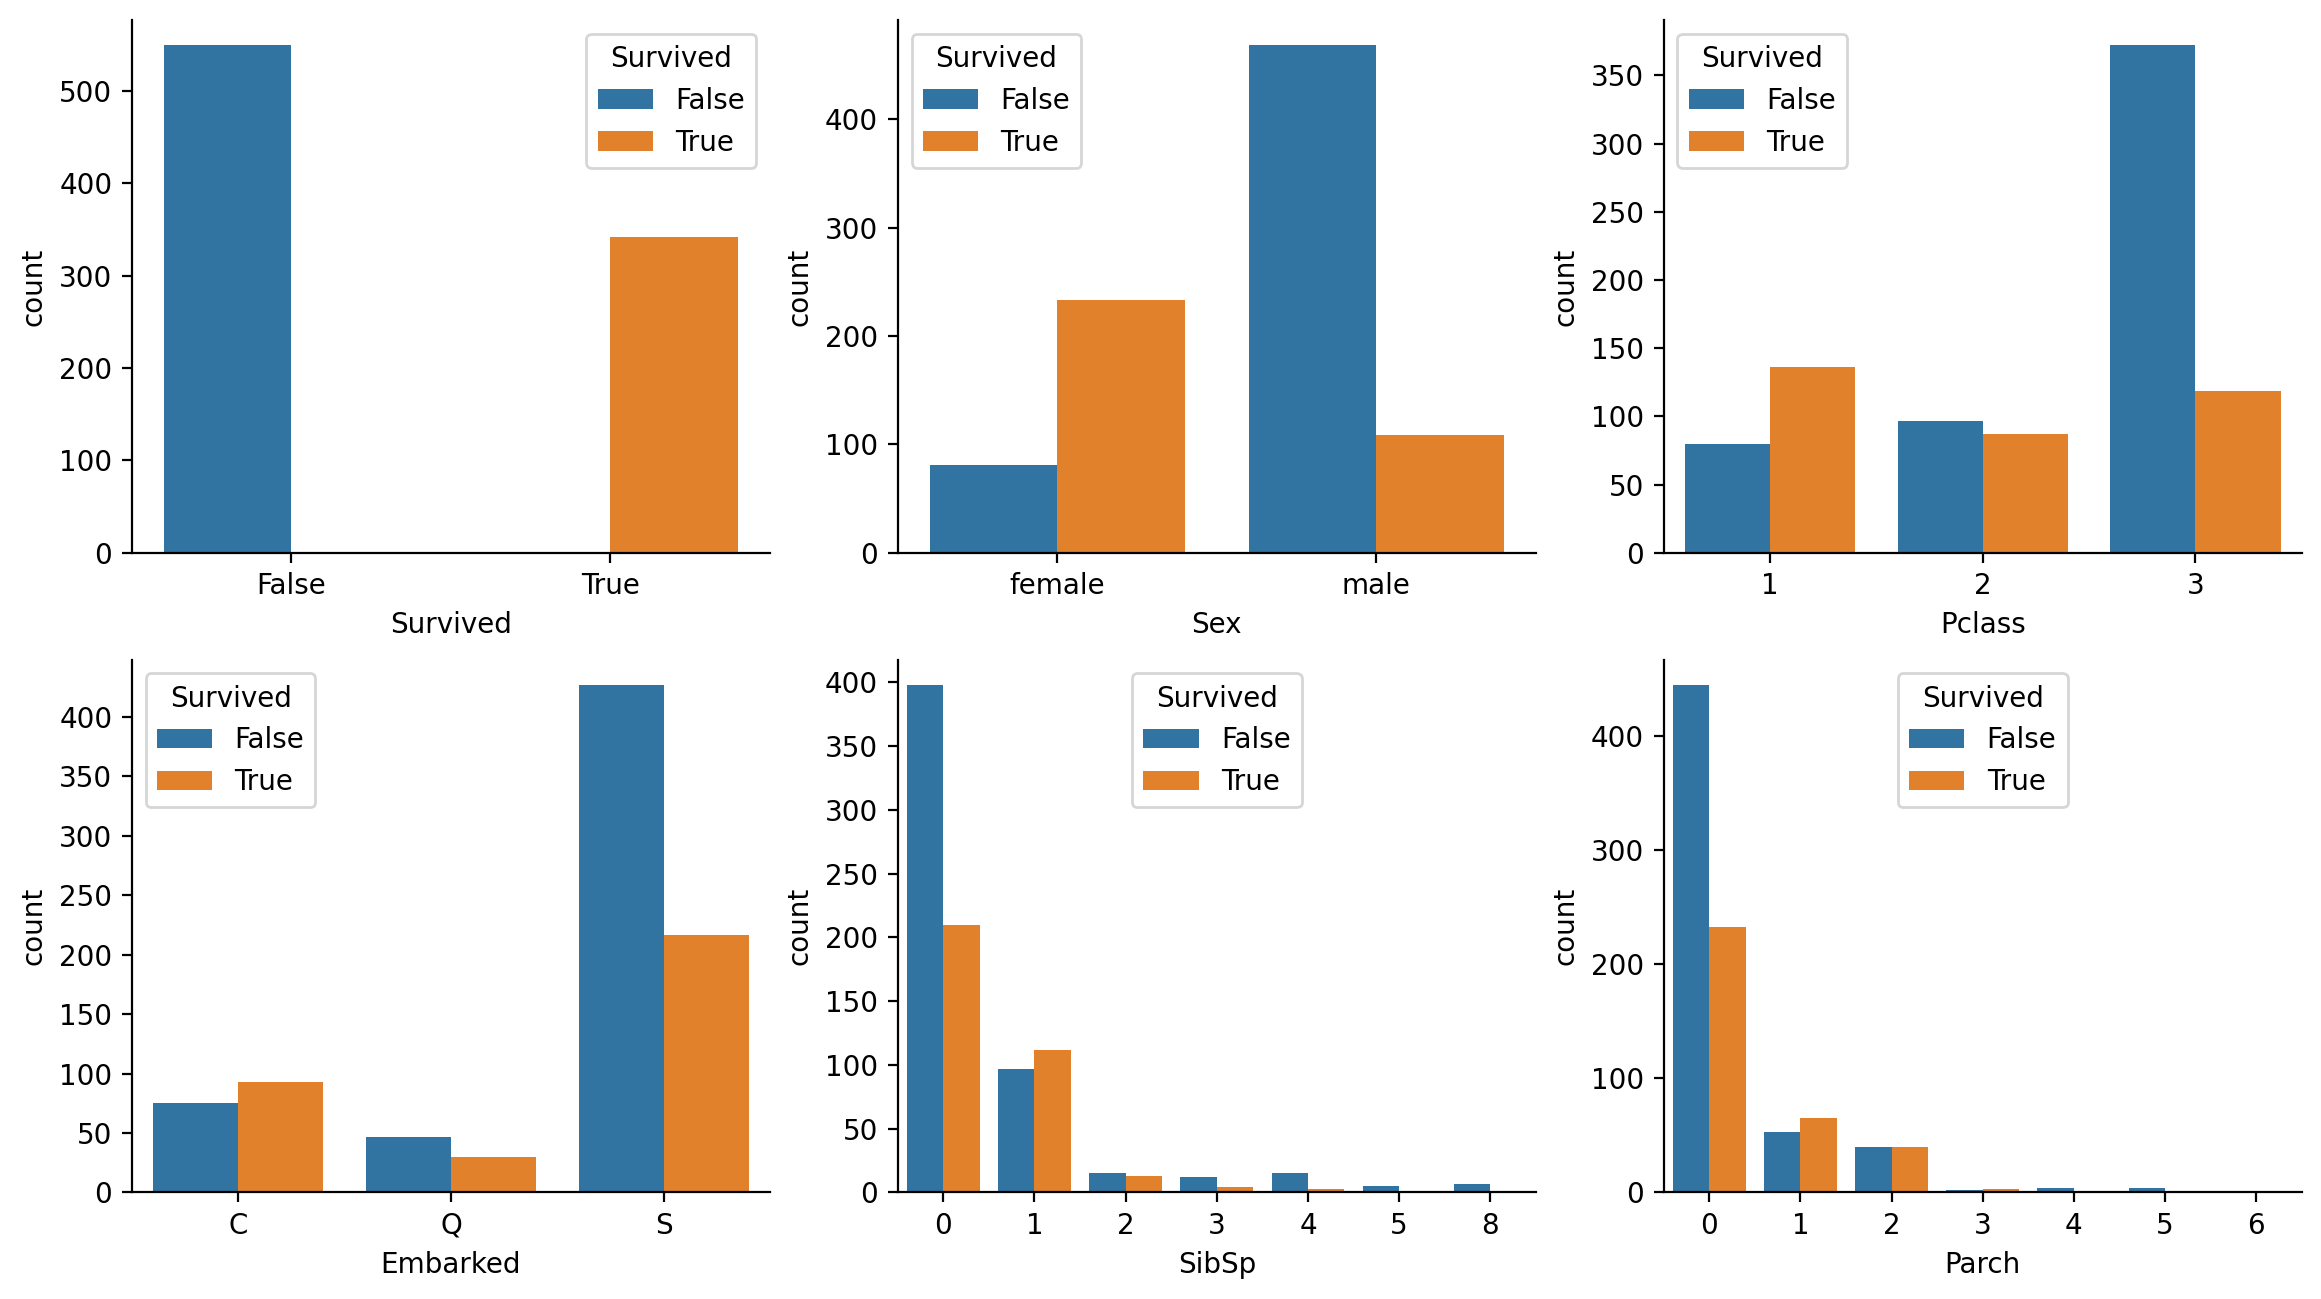

In [6]:
attributes = ['Survived','Sex','Pclass','Embarked','SibSp','Parch']

plt.figure(figsize=(14,12), dpi=200)

for i, feature in enumerate(attributes):
  plt.subplot(3,3,i+1)
  sns.countplot(data=titanic, x=feature, hue='Survived')

sns.despine()

데이터 전처리

In [7]:
titanic['Name'].iloc[0:5]

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: category
Categories (891, object): ['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
                           'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel', ..., 'de Pelsmaeker, Mr. Alfons',
                           'del Carlo, Mr. Sebastiano', 'van Billiard, Mr. Austin Blyler',
                           'van Melkebeke, Mr. Philemon']

In [8]:
def get_title(name) :
  return re.split(',|\.', name)[1].strip()

In [9]:
# 이름에서 호칭 추출(Miss, Mr, Mrs ...)
titanic['title'] = titanic['Name'].apply(get_title)

In [10]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
PassengerId,,,,,,,,,,,,
1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [11]:
# 호칭이 생존에 과연 영향을 끼치는지 확인을 위해서 집계 함수 -> 카운트, 평균
titles = titanic.groupby('title').agg({'Survived' : ['count', 'mean']})

In [12]:
titles

Survived          
                count      mean
title                          
Capt                1  0.000000
Col                 2  0.500000
Don                 1  0.000000
Dr                  7  0.428571
Jonkheer            1  0.000000
Lady                1  1.000000
Major               2  0.500000
Master             40  0.575000
Miss              182  0.697802
Mlle                2  1.000000
Mme                 1  1.000000
Mr                517  0.156673
Mrs               125  0.792000
Ms                  1  1.000000
Rev                 6  0.000000
Sir                 1  1.000000
the Countess        1  1.000000

In [13]:
# Survived 컬럼 레이어 정리
titles.columns = titles.columns.droplevel()

In [14]:
titles

,count,mean
title,,
Capt,1,0.000000
Col,2,0.500000
Don,1,0.000000
Dr,7,0.428571
Jonkheer,1,0.000000
Lady,1,1.000000
Major,2,0.500000
Master,40,0.575000
Miss,182,0.697802


In [15]:
# 생존 평균이 높은 순으로 정렬
titles.sort_values('mean', ascending=False)

,count,mean
title,,
the Countess,1,1.000000
Mlle,2,1.000000
Sir,1,1.000000
Ms,1,1.000000
Lady,1,1.000000
Mme,1,1.000000
Mrs,125,0.792000
Miss,182,0.697802
Master,40,0.575000


In [16]:
# 호칭 추출이 되지 않은 title 값을 Other로 처리
uncommon_titles = (['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 
                    'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 
                    'the Countess', 'Jonkheer'])

titanic['title'] = titanic['title'].replace(uncommon_titles, 'other')

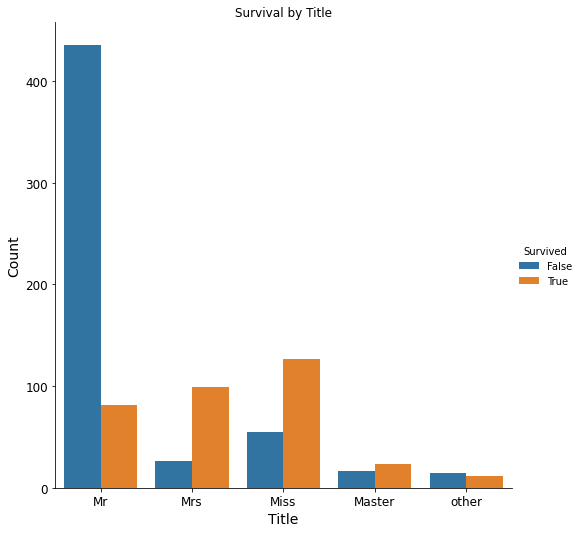

In [17]:
sns.catplot(x='title', kind='count', hue='Survived', 
            data=titanic, height=7)

plt.tick_params(labelsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Title', fontsize=14)
plt.title('Survival by Title')
plt.show()

In [18]:
# 가족 사이즈(fam_size) -> Sibsp(동승한 자매 or 배우지) + Parch(동승한 부모 or 자식수)
titanic['fam_size'] = titanic['SibSp'] + titanic['Parch']

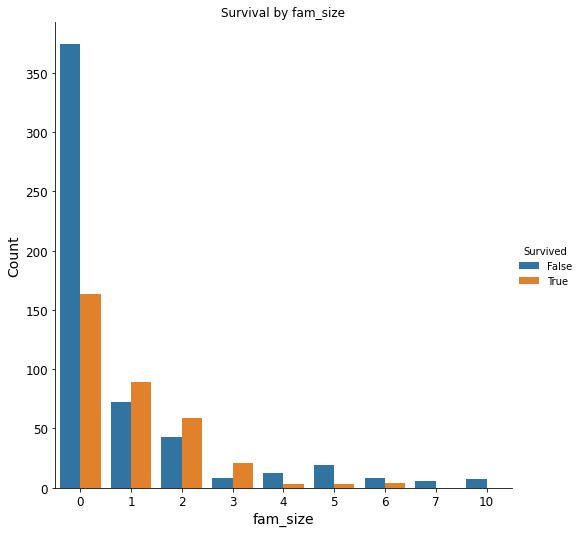

In [19]:
sns.catplot(x='fam_size', kind='count', hue='Survived', 
            data=titanic, height=7)

plt.tick_params(labelsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('fam_size', fontsize=14)
plt.title('Survival by fam_size')
plt.show()

ML을 위한 전처리

In [20]:
# 텍스트 데이터 삭제
titanic = titanic.drop(['Name','Ticket','Cabin', 'Embarked','title'], axis=1)

In [21]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,male,22.0,1,0,7.2500,1
2,True,1,female,38.0,1,0,71.2833,1
3,True,3,female,26.0,0,0,7.9250,0
4,True,1,female,35.0,1,0,53.1000,1
5,False,3,male,35.0,0,0,8.0500,0


In [22]:
# 여성을 1로 남성을 0으로 처리
tmp = []
for each in titanic['Sex']:
  if each == 'female':
    tmp.append(1)
  elif each == 'male':
    tmp.append(0)
  else:
    tmp.append(np.nan)

titanic['Sex'] = tmp

In [23]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,fam_size
PassengerId,,,,,,,,
1,False,3,0,22.0,1,0,7.2500,1
2,True,1,1,38.0,1,0,71.2833,1
3,True,3,1,26.0,0,0,7.9250,0
4,True,1,1,35.0,1,0,53.1000,1
5,False,3,0,35.0,0,0,8.0500,0


데이터 형변환 및 결손 데이터 처리

In [24]:
# 데이터 형 변환 (소수점)
titanic['Pclass'] = titanic['Pclass'].astype('float')
titanic['Sex'] = titanic['Sex'].astype('float')
titanic['SibSp'] = titanic['SibSp'].astype('float')
titanic['Parch'] = titanic['Parch'].astype('float')
titanic['Fare'] = titanic['Fare'].astype('float')

#null(결손) 값인 경우 삭제
titanic = titanic[titanic['Survived'].notnull()]
titanic = titanic[titanic['Age'].notnull()]
titanic = titanic[titanic['SibSp'].notnull()]
titanic = titanic[titanic['Parch'].notnull()]
titanic = titanic[titanic['Fare'].notnull()]

titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    bool   
 1   Pclass    714 non-null    float64
 2   Sex       714 non-null    float64
 3   Age       714 non-null    float64
 4   SibSp     714 non-null    float64
 5   Parch     714 non-null    float64
 6   Fare      714 non-null    float64
 7   fam_size  714 non-null    int64  
dtypes: bool(1), float64(6), int64(1)
memory usage: 45.3 KB


데이터 분리 하기 X(문제집), y(정답)

In [25]:
titanic_labels = titanic['Survived'].copy()
titanic = titanic.drop('Survived', axis=1)

훈련 데이터, 테스트데이터셋 분리하기

In [26]:
X_train, X_test, y_train,y_test = train_test_split(titanic,
                                                   titanic_labels,
                                                   train_size=0.8)

머신러닝 모델 구축 - 1) LogisticRegression

In [27]:
log_reg = LogisticRegression().fit(X_train,y_train)

In [28]:
# 정확도 확인
print('Train data Score : ', log_reg.score(X_train,y_train))
print('Test data Score : ', log_reg.score(X_test,y_test))

Train data Score :  0.8021015761821366
Test data Score :  0.8041958041958042


머신러닝 모델 구축 -2) Decision Tree

In [29]:
tree = DecisionTreeClassifier(max_depth=5, 
                              min_samples_leaf=20,
                              min_samples_split=40).fit(X_train, y_train)

In [30]:
# 정확도 확인
print('Train data Score:', tree.score(X_train,y_train))
print('Test data Score:', tree.score(X_test,y_test))

Train data Score: 0.8231173380035026
Test data Score: 0.8041958041958042


머신러닝 모델 구축 - 3) GradientBoostingClassifier

In [31]:
boost = GradientBoostingClassifier(max_depth=3,
                                   learning_rate=0.05).fit(X_train, y_train)

In [32]:
# 정확도 확인
print('Train data Score : ', boost.score(X_train,y_train))
print('Test data Score : ', boost.score(X_test,y_test))

Train data Score :  0.8739054290718039
Test data Score :  0.8111888111888111


머신러닝 모델 구축 - 4) RandomForestClassifier

In [33]:
random = RandomForestClassifier(n_estimators=300,
                                random_state=0).fit(X_train, y_train)

In [34]:
print('Train accuracy score is', random.score(X_train,y_train))
print('Test accuracy score is:', random.score(X_test,y_test))

Train accuracy score is 0.9912434325744308
Test accuracy score is: 0.8181818181818182


성능평가 - ROC 커브

In [35]:
def plot_auc_roc(model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

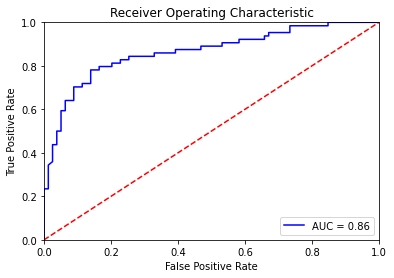

In [36]:
# Logistic Regression ROC
plot_auc_roc(log_reg)

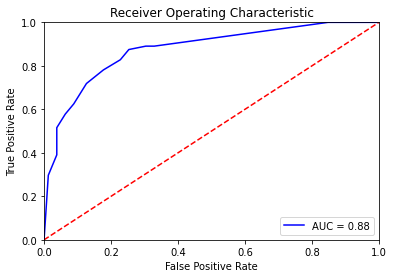

In [37]:
# Decision Tree
plot_auc_roc(tree)

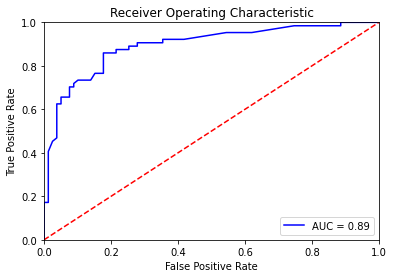

In [38]:
# GradientBoostingClassifie
plot_auc_roc(boost)

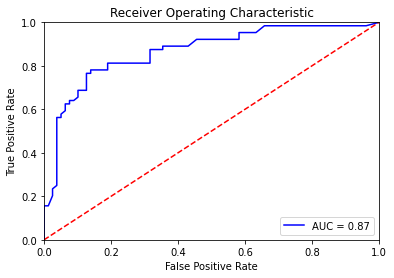

In [39]:
plot_auc_roc(random)

성능평가 - 평가 지표 (classification_report)

In [40]:
# Logistic Regression ROC 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가 지표')
print(lg_report)

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.79      0.87      0.83        79
        True       0.82      0.72      0.77        64

    accuracy                           0.80       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.80      0.80       143



In [41]:
# tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('tree 평가 지표')
print(tree_report)

tree 평가 지표
              precision    recall  f1-score   support

       False       0.79      0.87      0.83        79
        True       0.82      0.72      0.77        64

    accuracy                           0.80       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.80      0.80       143



In [42]:
# boost 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('boost 평가 지표')
print(boost_report)

boost 평가 지표
              precision    recall  f1-score   support

       False       0.78      0.92      0.84        79
        True       0.88      0.67      0.76        64

    accuracy                           0.81       143
   macro avg       0.83      0.80      0.80       143
weighted avg       0.82      0.81      0.81       143



In [43]:
# Random 평가 지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('Random 평가 지표')
print(random_report)

Random 평가 지표
              precision    recall  f1-score   support

       False       0.83      0.85      0.84        79
        True       0.81      0.78      0.79        64

    accuracy                           0.82       143
   macro avg       0.82      0.81      0.82       143
weighted avg       0.82      0.82      0.82       143



In [44]:
precision_list = []
recall_list = []

In [45]:
# Logistic Regression ROC 평가 지표
lg_y_hat = log_reg.predict(X_test)
lg_report = metrics.classification_report(y_test, lg_y_hat)
print('Logistic Regression 평가 지표')
print(lg_report)
print('accuracy', metrics.accuracy_score(y_test,lg_y_hat) )
print('precision', metrics.precision_score(y_test,lg_y_hat) )
print('recall', metrics.recall_score(y_test,lg_y_hat) )
print('f1', metrics.f1_score(y_test,lg_y_hat) )

Logistic Regression 평가 지표
              precision    recall  f1-score   support

       False       0.79      0.87      0.83        79
        True       0.82      0.72      0.77        64

    accuracy                           0.80       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.80      0.80       143

accuracy 0.8041958041958042
precision 0.8214285714285714
recall 0.71875
f1 0.7666666666666666


In [46]:
# tree 평가 지표
tree_y_hat = tree.predict(X_test)
tree_report = metrics.classification_report(y_test, tree_y_hat)
print('tree 평가 지표')
print(tree_report)
print('accuracy', metrics.accuracy_score(y_test,tree_y_hat) )
print('precision', metrics.precision_score(y_test,tree_y_hat) )
print('recall', metrics.recall_score(y_test,tree_y_hat) )
print('f1', metrics.f1_score(y_test,tree_y_hat) )

tree 평가 지표
              precision    recall  f1-score   support

       False       0.79      0.87      0.83        79
        True       0.82      0.72      0.77        64

    accuracy                           0.80       143
   macro avg       0.81      0.80      0.80       143
weighted avg       0.81      0.80      0.80       143

accuracy 0.8041958041958042
precision 0.8214285714285714
recall 0.71875
f1 0.7666666666666666


In [47]:
# boost 평가 지표
boost_y_hat = boost.predict(X_test)
boost_report = metrics.classification_report(y_test, boost_y_hat)
print('boost 평가 지표')
print(boost_report)

print('accuracy', metrics.accuracy_score(y_test,boost_y_hat) )
print('precision', metrics.precision_score(y_test,boost_y_hat) )
# Precision : 예측한 모델 중 실제 사람이 있는 비율

print('recall', metrics.recall_score(y_test,boost_y_hat) )
# Recall :실제 중 모델이 심장병이라 예측한 사람
# Recall 높을수록 오진단 (심장병인데 아니라는 진단을 낮추려면 Recall이 낮아야한다.)
# Recall을 중점으로 봐야함
# Recall이 제일 높은 모델을 선택해야 한다.

print('f1', metrics.f1_score(y_test,boost_y_hat) )
# 둘 다 중요하다면 f1 score를 확인한다.

boost 평가 지표
              precision    recall  f1-score   support

       False       0.78      0.92      0.84        79
        True       0.88      0.67      0.76        64

    accuracy                           0.81       143
   macro avg       0.83      0.80      0.80       143
weighted avg       0.82      0.81      0.81       143

accuracy 0.8111888111888111
precision 0.8775510204081632
recall 0.671875
f1 0.7610619469026548


In [48]:
# Random 평가 지표
random_y_hat = random.predict(X_test)
random_report = metrics.classification_report(y_test, random_y_hat)
print('Random 평가 지표')
print(random_report)
print('accuracy', metrics.accuracy_score(y_test,random_y_hat) )
print('precision', metrics.precision_score(y_test,random_y_hat) )
print('recall', metrics.recall_score(y_test,random_y_hat) )
print('f1', metrics.f1_score(y_test,random_y_hat) )

Random 평가 지표
              precision    recall  f1-score   support

       False       0.83      0.85      0.84        79
        True       0.81      0.78      0.79        64

    accuracy                           0.82       143
   macro avg       0.82      0.81      0.82       143
weighted avg       0.82      0.82      0.82       143

accuracy 0.8181818181818182
precision 0.8064516129032258
recall 0.78125
f1 0.7936507936507936


성능평가 - precision_score,recall_score 각 모델별로 추출한 후 그래프로 시각화

In [49]:
precision_list = []
recall_list = []



precision_list.append(metrics.precision_score(y_test,lg_y_hat))
recall_list.append(metrics.recall_score(y_test,lg_y_hat))

precision_list.append(metrics.precision_score(y_test,tree_y_hat))
recall_list.append(metrics.recall_score(y_test,tree_y_hat))

precision_list.append(metrics.precision_score(y_test,boost_y_hat))
recall_list.append(metrics.recall_score(y_test,boost_y_hat))

precision_list.append(metrics.precision_score(y_test,random_y_hat))
recall_list.append(metrics.recall_score(y_test,random_y_hat))

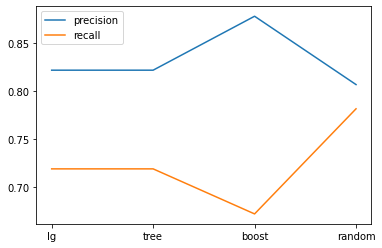

In [52]:
plt.plot(['lg', 'tree', 'boost','random'],precision_list, label='precision')
plt.plot(['lg', 'tree', 'boost','random'],recall_list, label='recall')
plt.legend()
plt.show()
# 사망, 진료 등은 recall, 추천 알고리즘은 precision

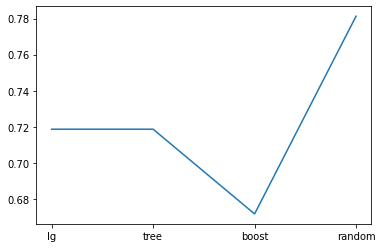

In [51]:
plt.plot(['lg','tree','boost','random'],recall_list)